## Relax Take Home Challenge

### Import Libraries

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier

In [16]:
### The regular read_csv method gave me a fight with encoding, so let's figure that out first:
with open('takehome_user_engagement.csv') as f:
    print(f)
###which is interesting bc it is not right; file info in Finder lists it as cp1252, a Windows encoding


<_io.TextIOWrapper name='takehome_user_engagement.csv' mode='r' encoding='UTF-8'>


In [20]:
### The regular 
users_df = pd.read_csv("takehome_users.csv",  encoding = "cp1252")
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [19]:
engagement_df = pd.read_csv("takehome_user_engagement.csv",  encoding = "cp1252")
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [21]:
### Need to get a few coulmns into datetime format
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [22]:
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])

In [23]:
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'])

In [24]:
users_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [27]:
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [34]:
### With datetimes set, let's figure out the "adopted user" categorization
### Let's just work on a copy of the engagement_df and sort by user visits by day.
df = engagement_df
### grabbing the date by itself https://www.geeksforgeeks.org/python-pandas-series-dt-date/
df['date'] = df.time_stamp.dt.date
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
 3   date        207917 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.3+ MB


In [35]:
df['date'] = pd.to_datetime(df['date'])

In [36]:
### will need rolling: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html
def count_rolling(df_group, period):
    return df_group.rolling(period, on='date')['user_id'].count()
### user_id is one per log in, so can substitute cleanly for visited

In [37]:
###https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html 
### Need to suppress a few defaults after getting some messy output
df['rolling_seven_visits'] = df.groupby('user_id', as_index=False, group_keys=False).apply(count_rolling, '7D')


In [38]:
### So we have visits in a seven day period but now a user must have 3 or more visits
### to count as an adopted user, so . . . .
df.head()

,time_stamp,user_id,visited,date,rolling_seven_visits
0,2014-04-22 03:53:30,1,1,2014-04-22,1.0
1,2013-11-15 03:45:04,2,1,2013-11-15,1.0
2,2013-11-29 03:45:04,2,1,2013-11-29,1.0
3,2013-12-09 03:45:04,2,1,2013-12-09,1.0
4,2013-12-25 03:45:04,2,1,2013-12-25,1.0


In [68]:
### grouping by user id and the max value to a new dataframe, on the assumption that if the max value
### of a user is 1 or 2, then the user cannot be an adopted user.
adopted = df.groupby('user_id')['rolling_seven_visits'].max().reset_index()
adopted.head(10)

,user_id,rolling_seven_visits
0,1,1.0
1,2,3.0
2,3,1.0
3,4,1.0
4,5,1.0
5,6,1.0
6,7,1.0
7,10,7.0
8,11,1.0
9,13,1.0


In [69]:
###Now need a binary designation for adopted/not adopted for visits that are 3 or greater
adopted['adopted'] = adopted['rolling_seven_visits'].apply(lambda x: 1 if x>=3 else 0)

In [70]:
adopted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8823 entries, 0 to 8822
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               8823 non-null   int64  
 1   rolling_seven_visits  8823 non-null   float64
 2   adopted               8823 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 206.9 KB


In [71]:
### So not that many adopted users; about 22%
adopted.adopted.value_counts()

0    7221
1    1602
Name: adopted, dtype: int64

In the takehome_users data the object_id is the user_id, so we need to switch over that column, and the only two columns we need are the user_id and adopted binary classification. So let's set the index to user_id (renamed as object_id) and drop the other column.

In [72]:
adopted.drop('rolling_seven_visits', inplace=True, axis=1)

In [74]:
adopted.rename(columns={'user_id':'object_id'}, inplace=True)

In [76]:
adopted.set_index('object_id', inplace=True)
adopted.head()


,adopted
object_id,
1,0
2,1
3,0
4,0
5,0


In [89]:
### Now to join the newly created binary classification onto the original; We need a left join here
full_users = users_df.join(adopted, on='object_id', how='left')
full_users.tail()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1970-01-01 00:00:01.378448055,0,0,89,8263.0,0.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1970-01-01 00:00:01.358274517,0,0,200,NaN,0.0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1970-01-01 00:00:01.398602716,1,1,83,8074.0,0.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1970-01-01 00:00:01.338638159,0,0,6,NaN,0.0
11999,12000,2014-01-26 08:57:12,Lima Thaís,ThaisMeloLima@hotmail.com,SIGNUP,1970-01-01 00:00:01.390726632,0,1,0,NaN,0.0


In [81]:
### The last session creation has null, as does adopted  and invited by
### Probably safe to assume these would not be adopted users and can be made 0
### but in a real world situation would be best to check with marketing to see what other
### factors might contribute to adoption
full_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     8823 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)


In [84]:
full_users['last_session_creation_time'].fillna(0, inplace = True)
full_users['adopted'].fillna(0, inplace = True)
full_users['invited_by_user_id'].fillna(0, inplace=True)

In [85]:
full_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  object        
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  adopted                     12000 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)


In [88]:
full_users.describe().T

,count,mean,std,min,25%,50%,75%,max
object_id,12000.0,6000.500000,3464.245950,1.0,3000.75,6000.5,9000.25,12000.0
opted_in_to_mailing_list,12000.0,0.249500,0.432742,0.0,0.00,0.0,0.00,1.0
enabled_for_marketing_drip,12000.0,0.149333,0.356432,0.0,0.00,0.0,0.00,1.0
org_id,12000.0,141.884583,124.056723,0.0,29.00,108.0,238.25,416.0
invited_by_user_id,12000.0,3188.691333,3869.027693,0.0,0.00,875.0,6317.00,11999.0
adopted,12000.0,0.133500,0.340128,0.0,0.00,0.0,0.00,1.0


Last session creation time was used to figure out adopted users and the object_id here is essentially a duplicate index. Those two can be dropped as we head towards applying some machine learning to the transformed data. Email looks to be a healthy number of fake domains. But it would be good to know *how long* users have been taking part. We can create a number of days column to do date math before dropping last creation time.

In [91]:
full_users['days_since_creation'] = (engagement_df.time_stamp.max() - users_df.creation_time).dt.days

In [94]:
full_users.drop(columns=['object_id', 'email', 'last_session_creation_time'], inplace=True)

In [95]:
full_users.head()

,creation_time,name,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,days_since_creation
0,2014-04-22 03:53:30,Clausen August,GUEST_INVITE,1,0,11,10803.0,0.0,45
1,2013-11-15 03:45:04,Poole Matthew,ORG_INVITE,0,0,1,316.0,1.0,203
2,2013-03-19 23:14:52,Bottrill Mitchell,ORG_INVITE,0,0,94,1525.0,0.0,443
3,2013-05-21 08:09:28,Clausen Nicklas,GUEST_INVITE,0,0,1,5151.0,0.0,381
4,2013-01-17 10:14:20,Raw Grace,GUEST_INVITE,0,0,193,5240.0,0.0,505


In [96]:
### actually, name won't be useful for any machine learning assessment
full_users.drop(columns='name', inplace=True)

In [97]:
### and the importance of creation time is now stored in days since creation, so there also
full_users.drop(columns='creation_time', inplace=True)

In [98]:
###Creation source might be important, so let's splay that out by one hot encoding
full_users = pd.get_dummies(full_users, columns=['creation_source'])

In [99]:
full_users.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,days_since_creation,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803.0,0.0,45,1,0,0,0,0
1,0,0,1,316.0,1.0,203,0,1,0,0,0
2,0,0,94,1525.0,0.0,443,0,1,0,0,0
3,0,0,1,5151.0,0.0,381,1,0,0,0,0
4,0,0,193,5240.0,0.0,505,1,0,0,0,0


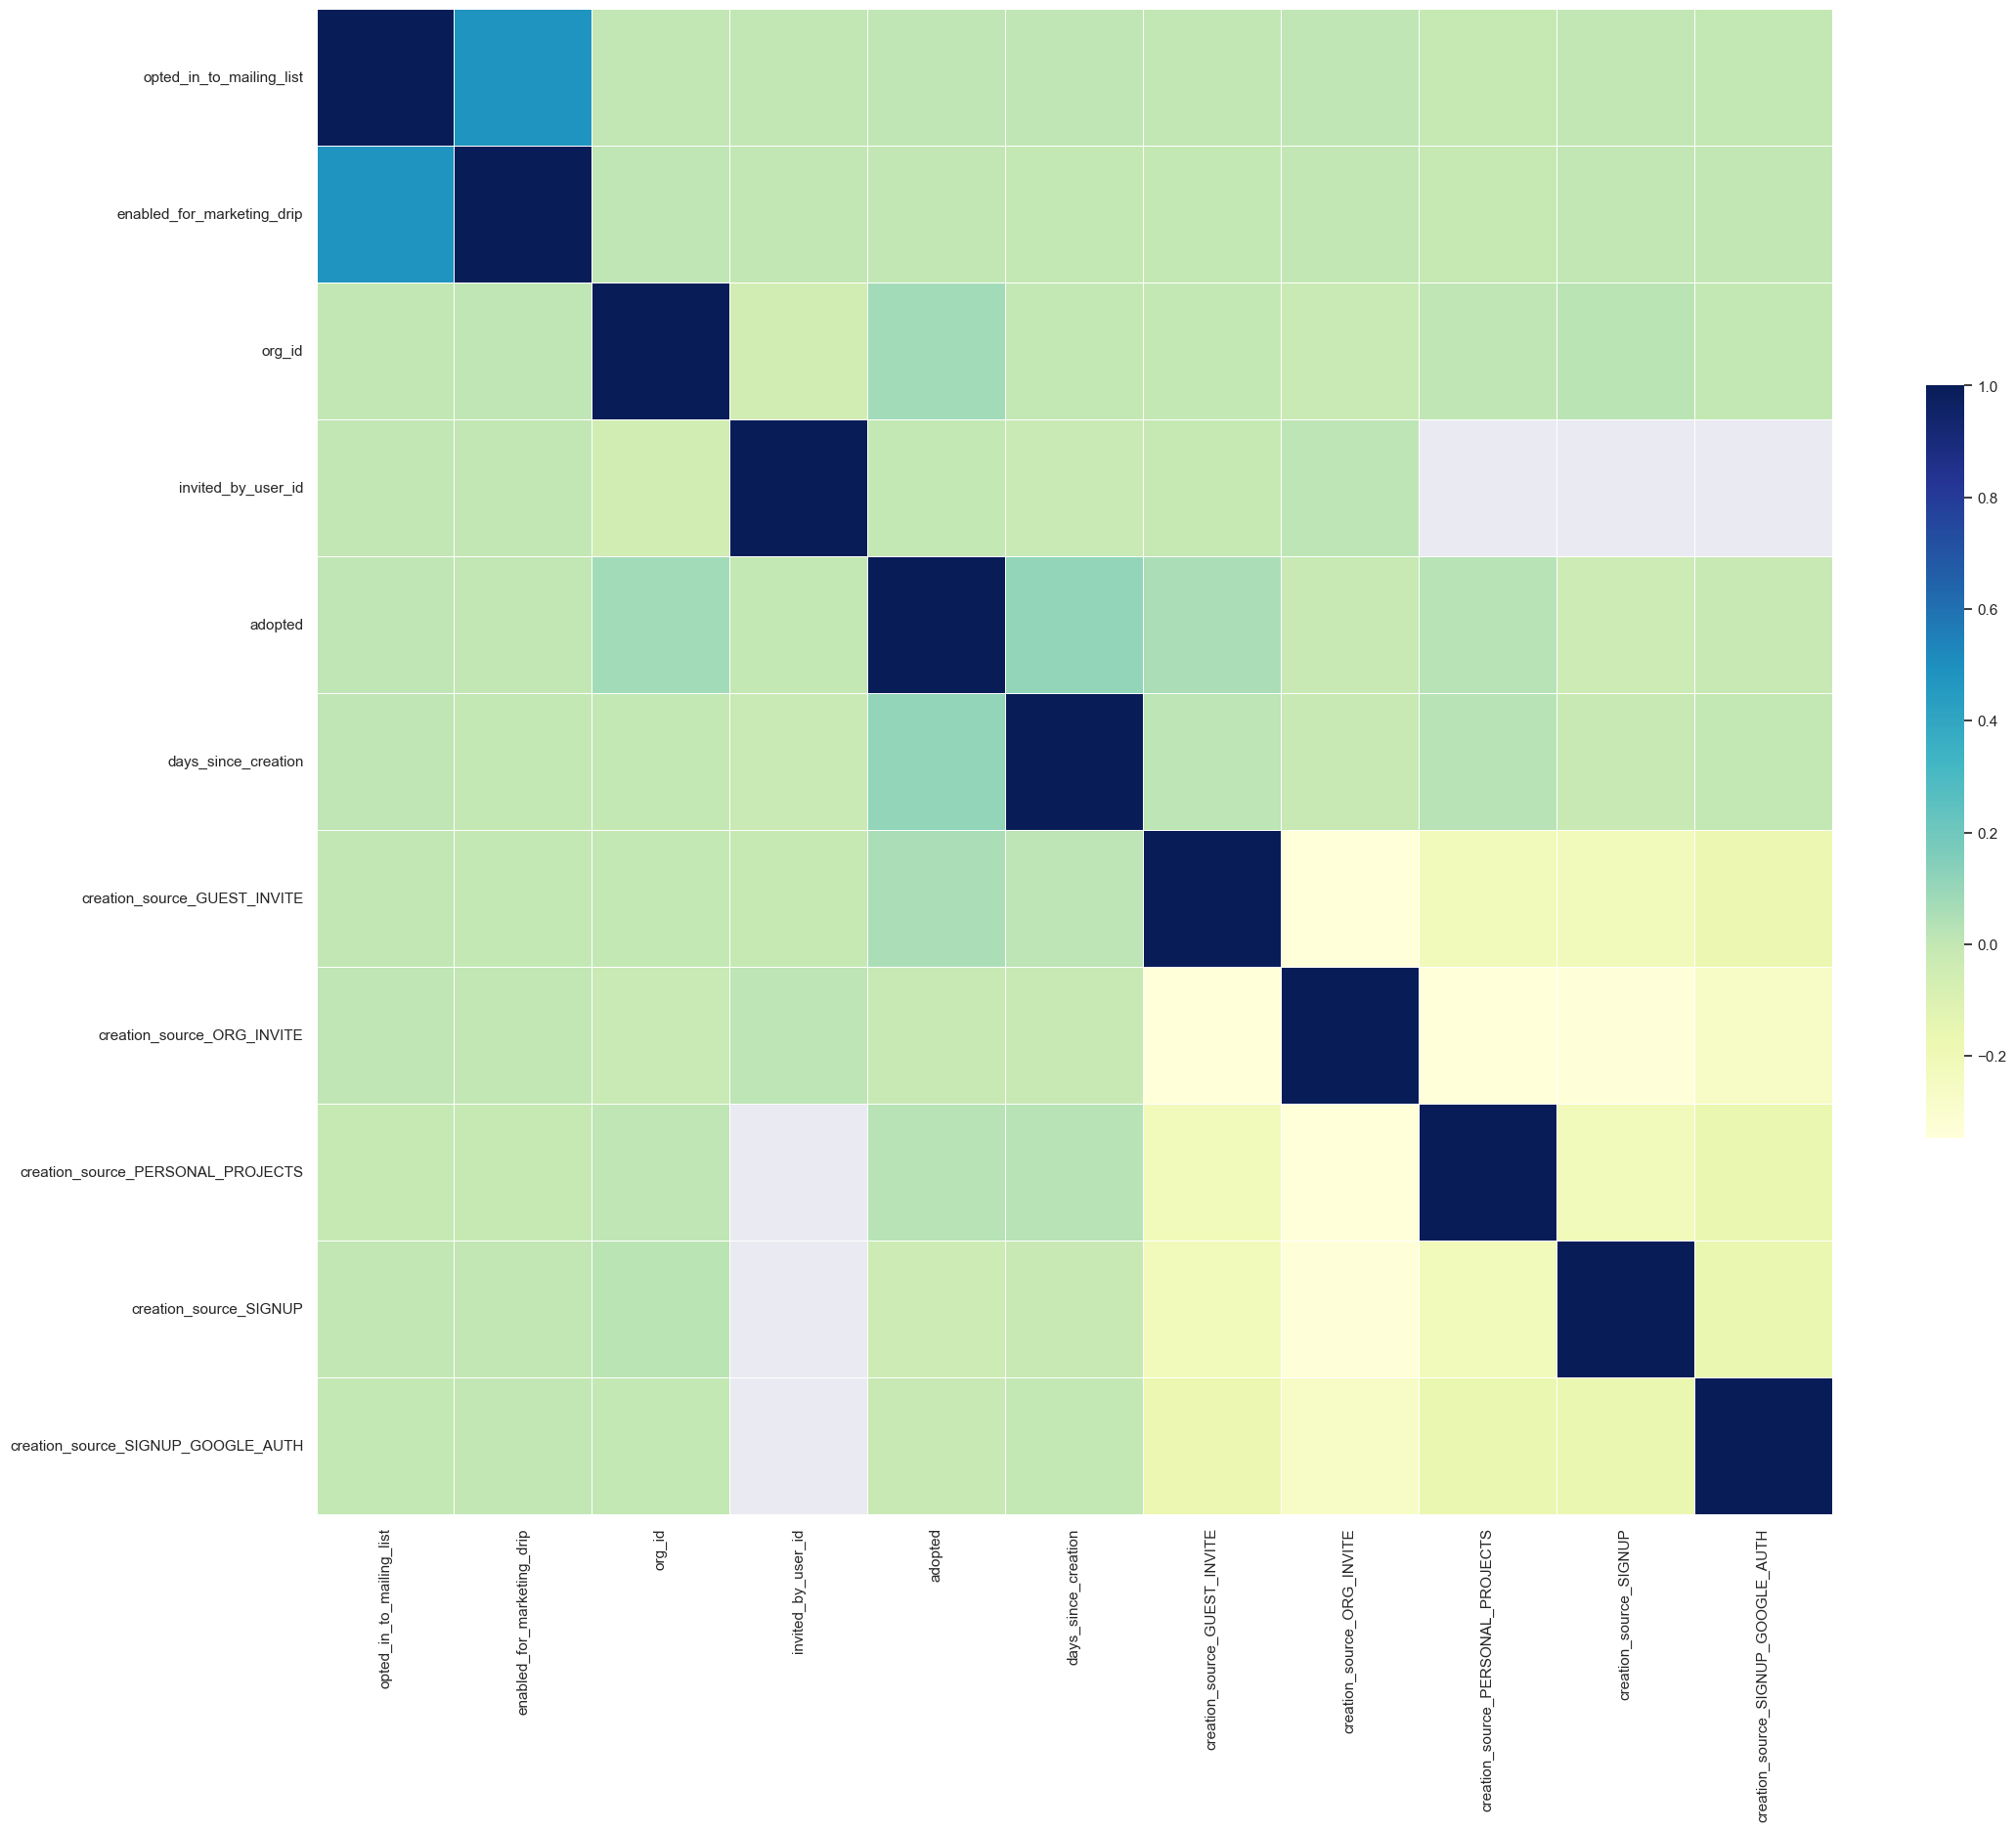

In [104]:
correlation_matrix = full_users.corr()
sns.set(rc = {'figure.figsize':(25,20)})
_ = sns.heatmap(correlation_matrix, cmap="YlGnBu", linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig('adopted_correlations')

Not a lot of strong correlations with adopted users, but it does make sense that if they opted into marketing list they were also enabled for the marketing drip. Days since creation seems to have some effect.

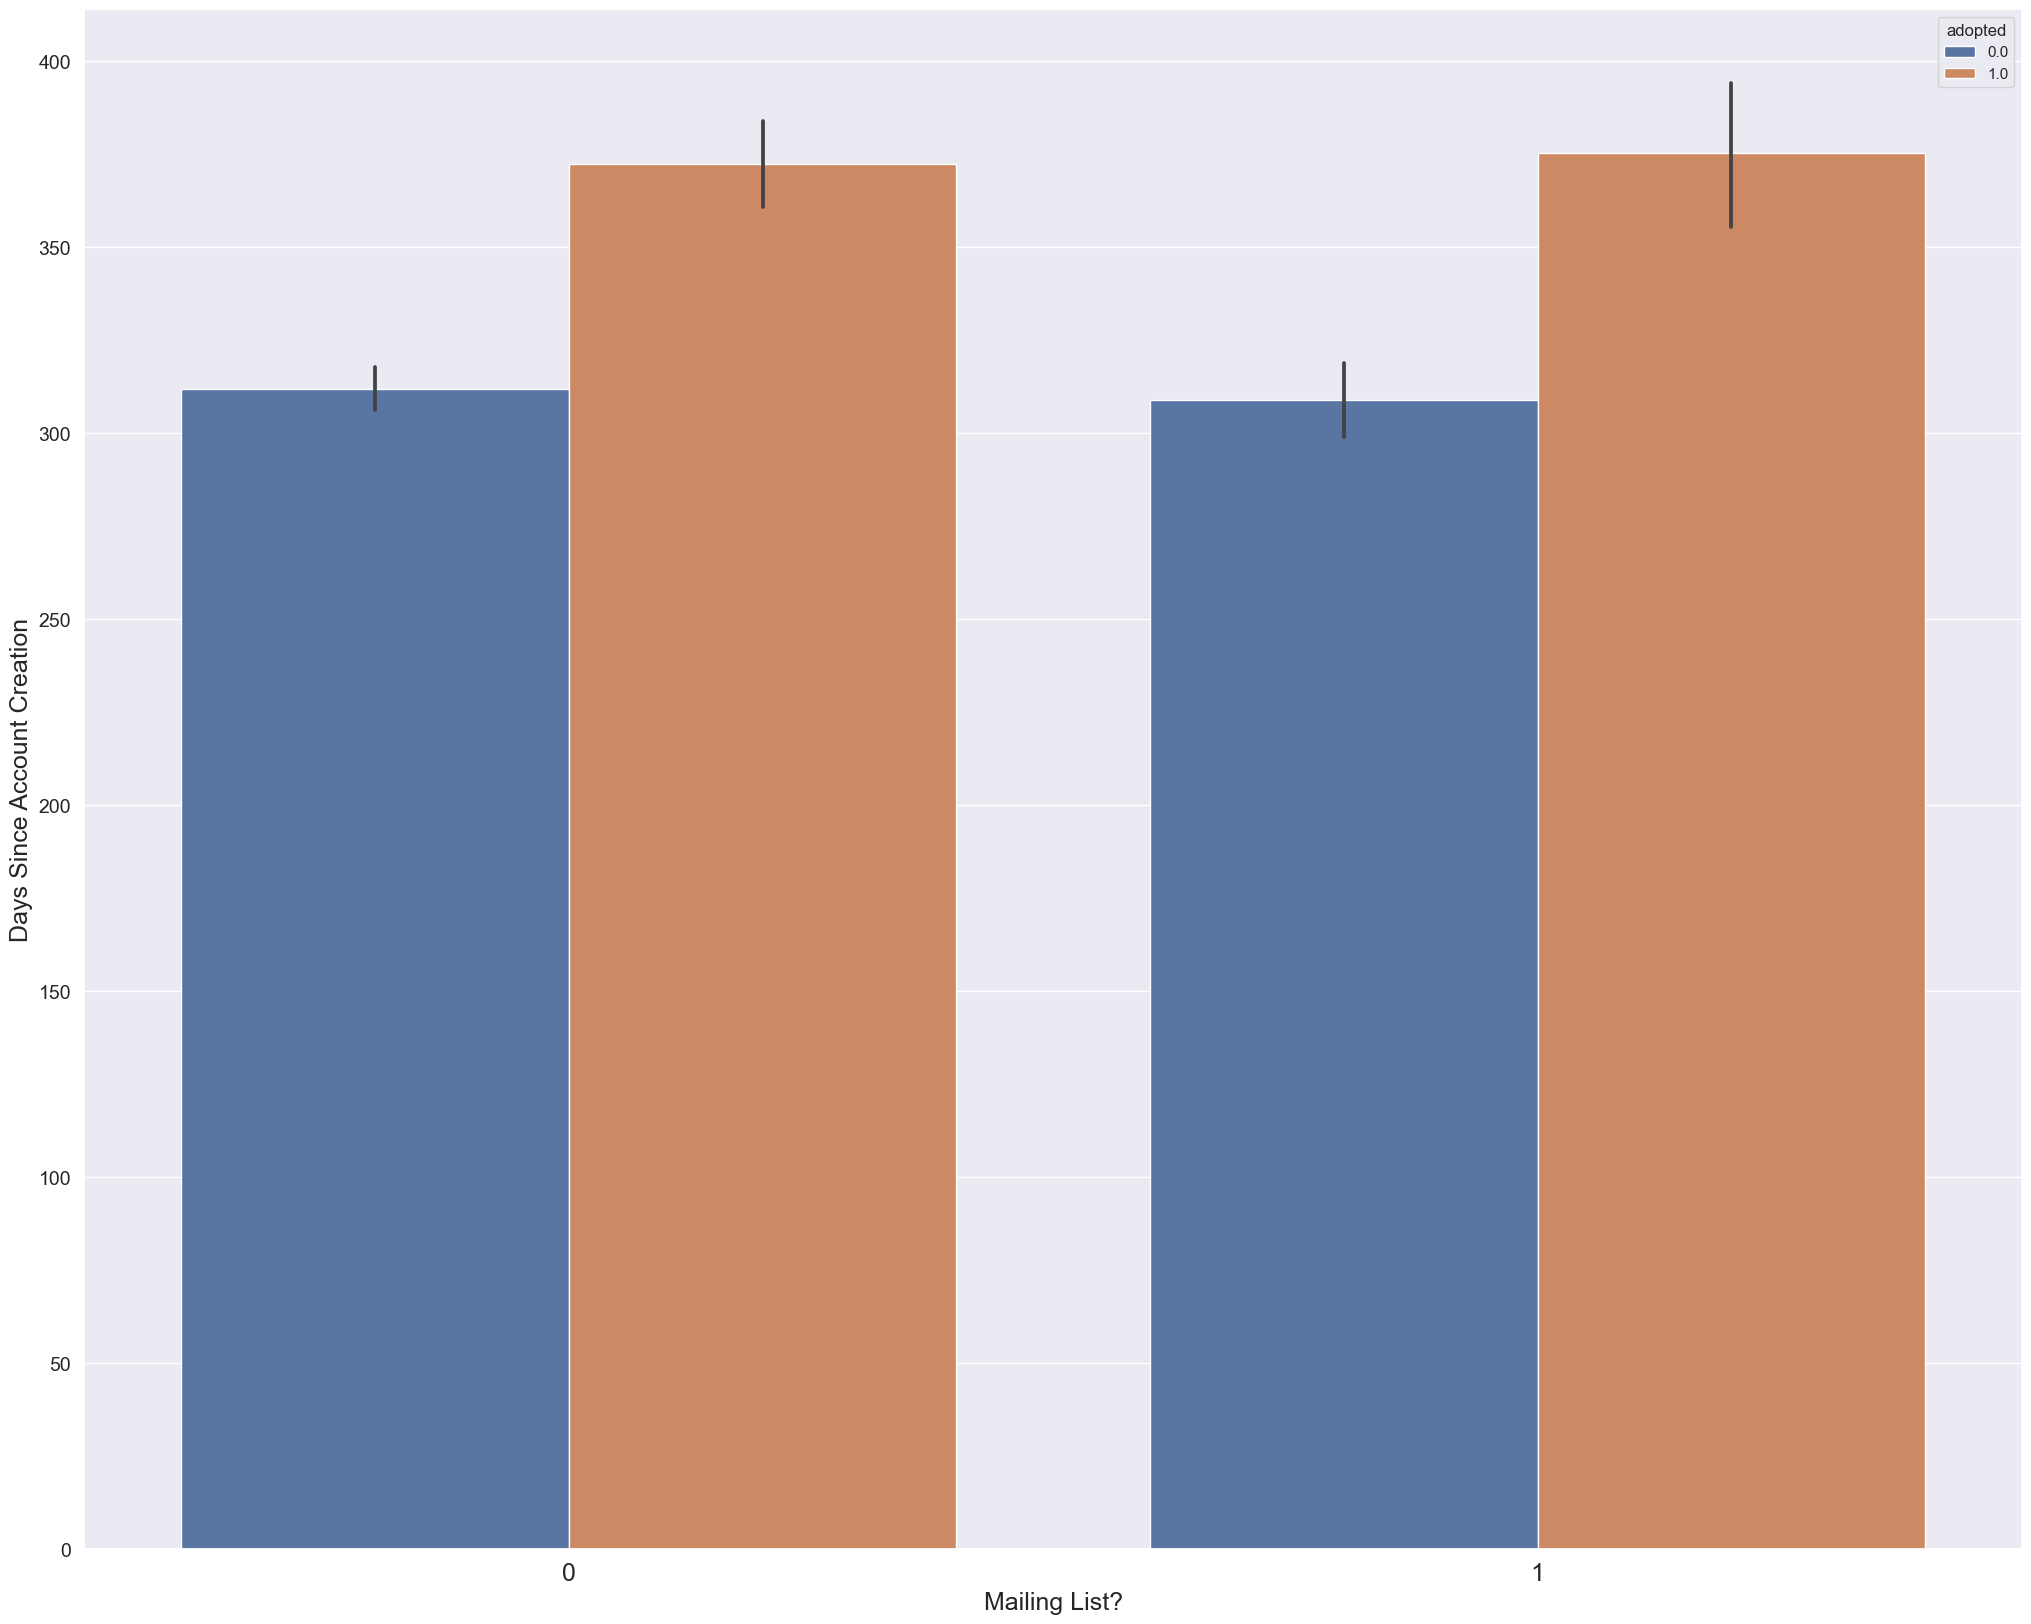

In [111]:
sns.barplot(y=full_users['days_since_creation'], x=full_users['opted_in_to_mailing_list'], hue=full_users['adopted'])
plt.xticks(rotation = 0, fontsize=18)
plt.xlabel('Mailing List?', fontsize=18)
plt.ylabel('Days Since Account Creation', fontsize=18)
plt.yticks(fontsize=14)
plt.show;
plt.savefig('Mailing List Option by Days on Platform')

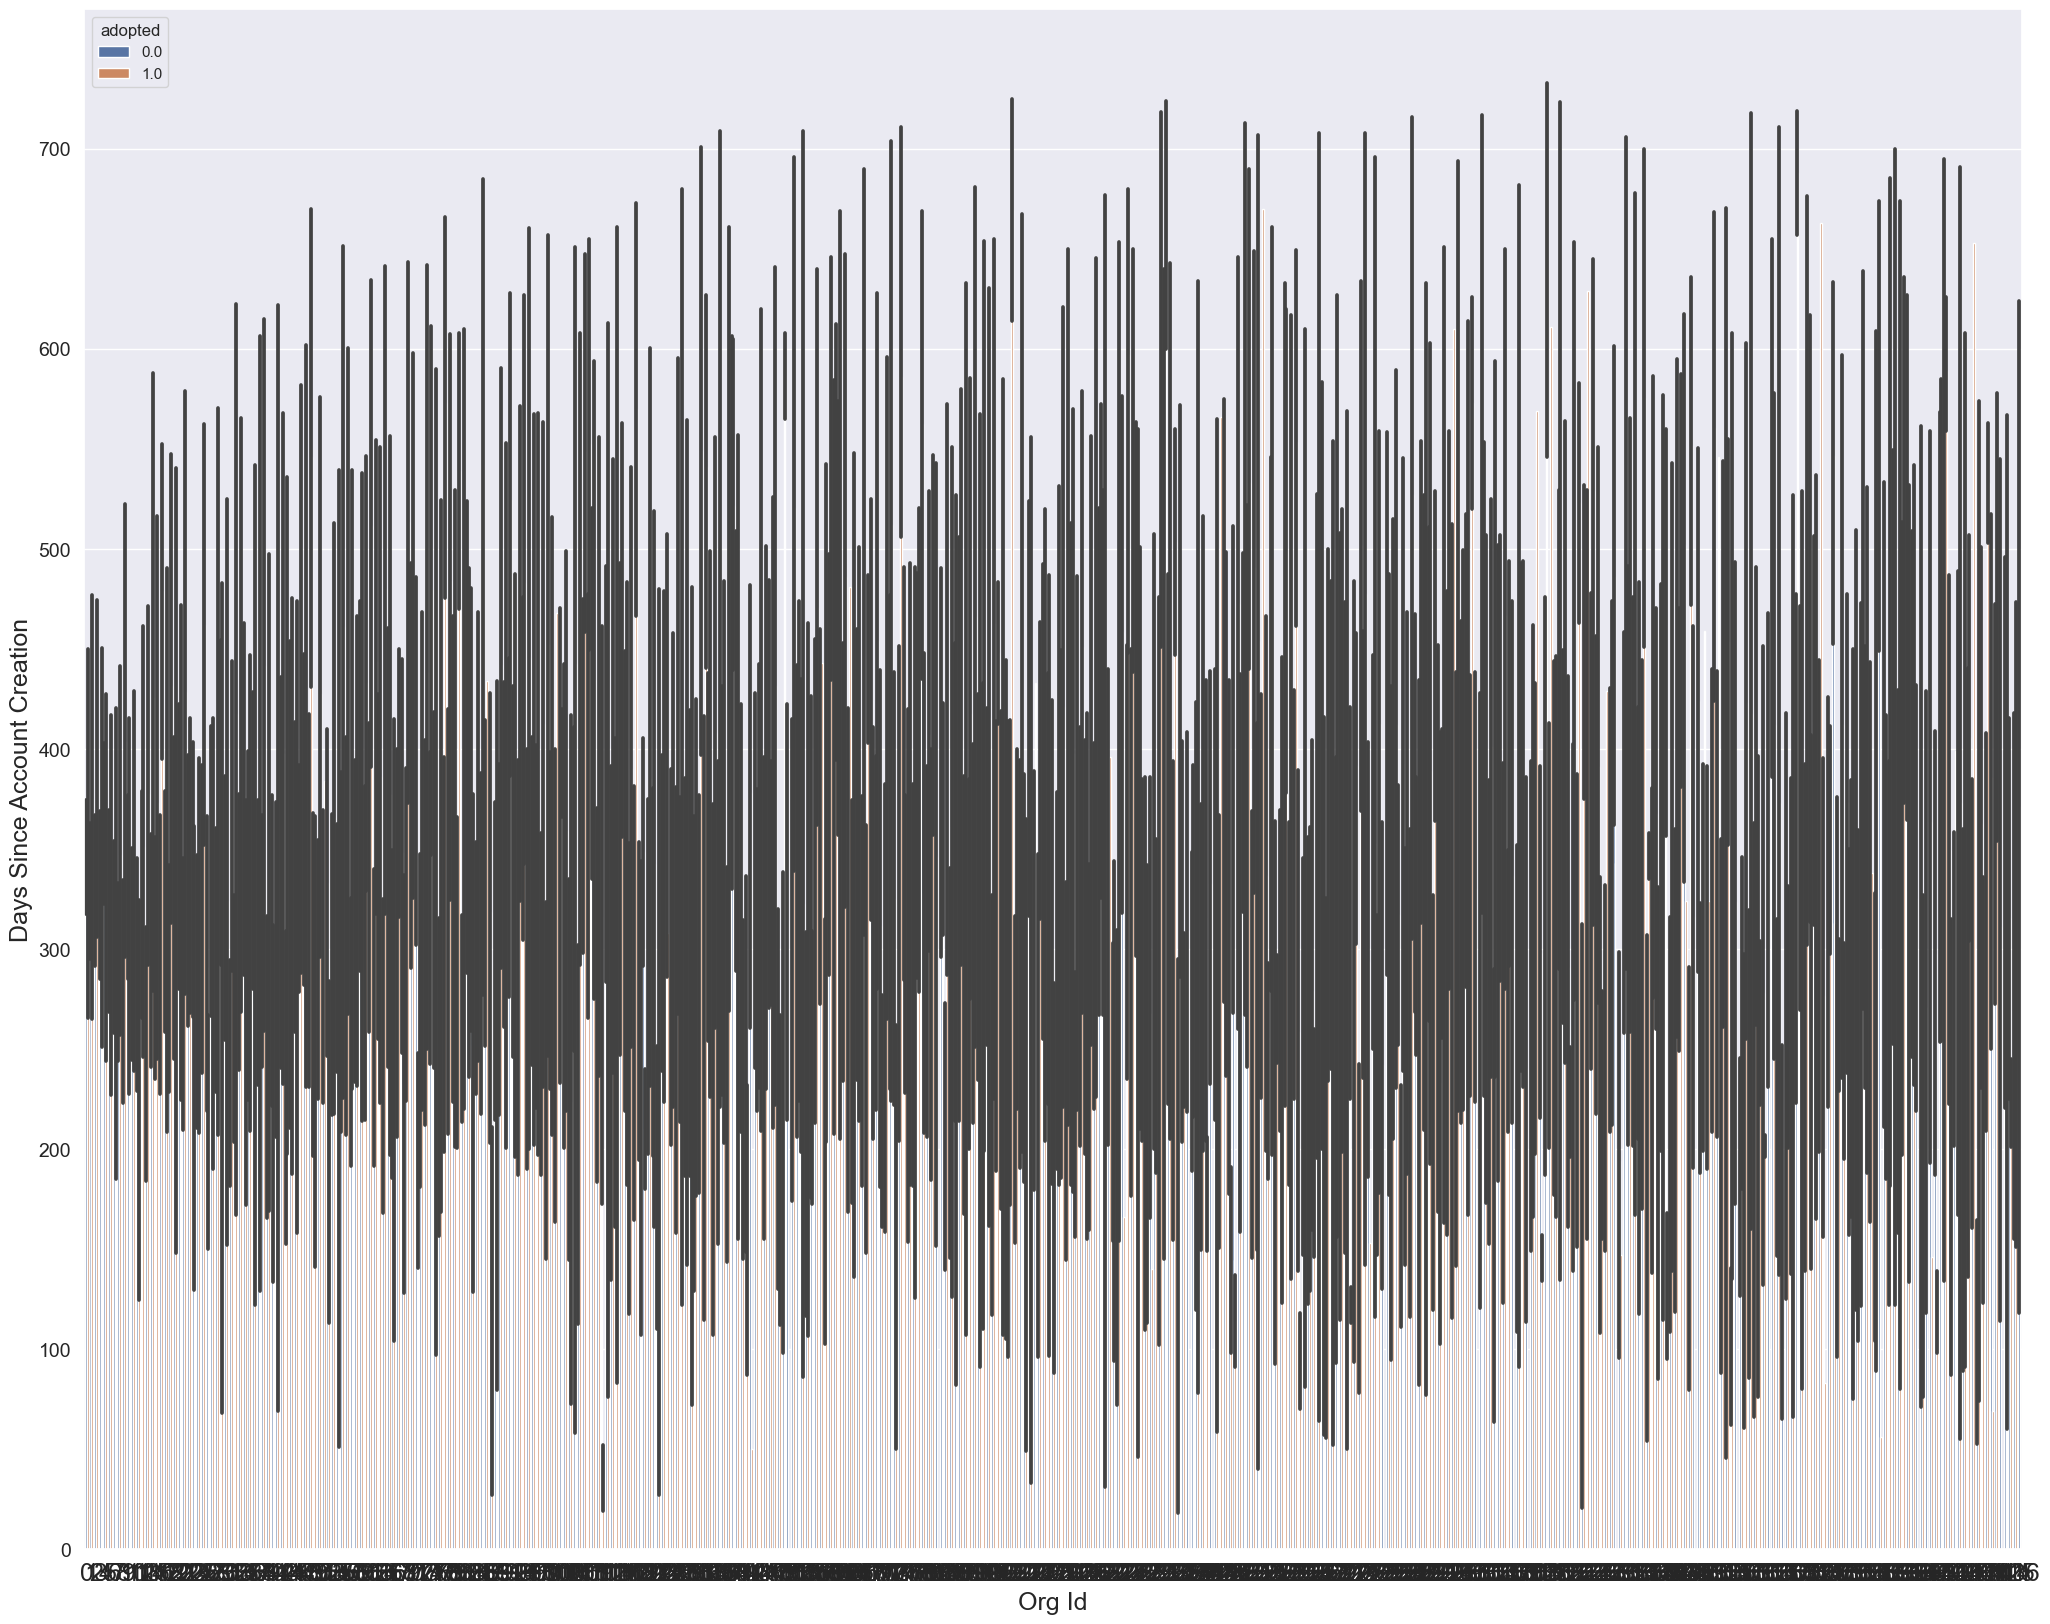

In [112]:
### It's pretty, like a waveform, but it is not useful
sns.barplot(y=full_users['days_since_creation'], x=full_users['org_id'], hue=full_users['adopted'])
plt.xticks(rotation = 0, fontsize=18)
plt.xlabel('Org Id', fontsize=18)
plt.ylabel('Days Since Account Creation', fontsize=18)
plt.yticks(fontsize=14)
plt.show;
plt.savefig('Org ID by Days on Platform')

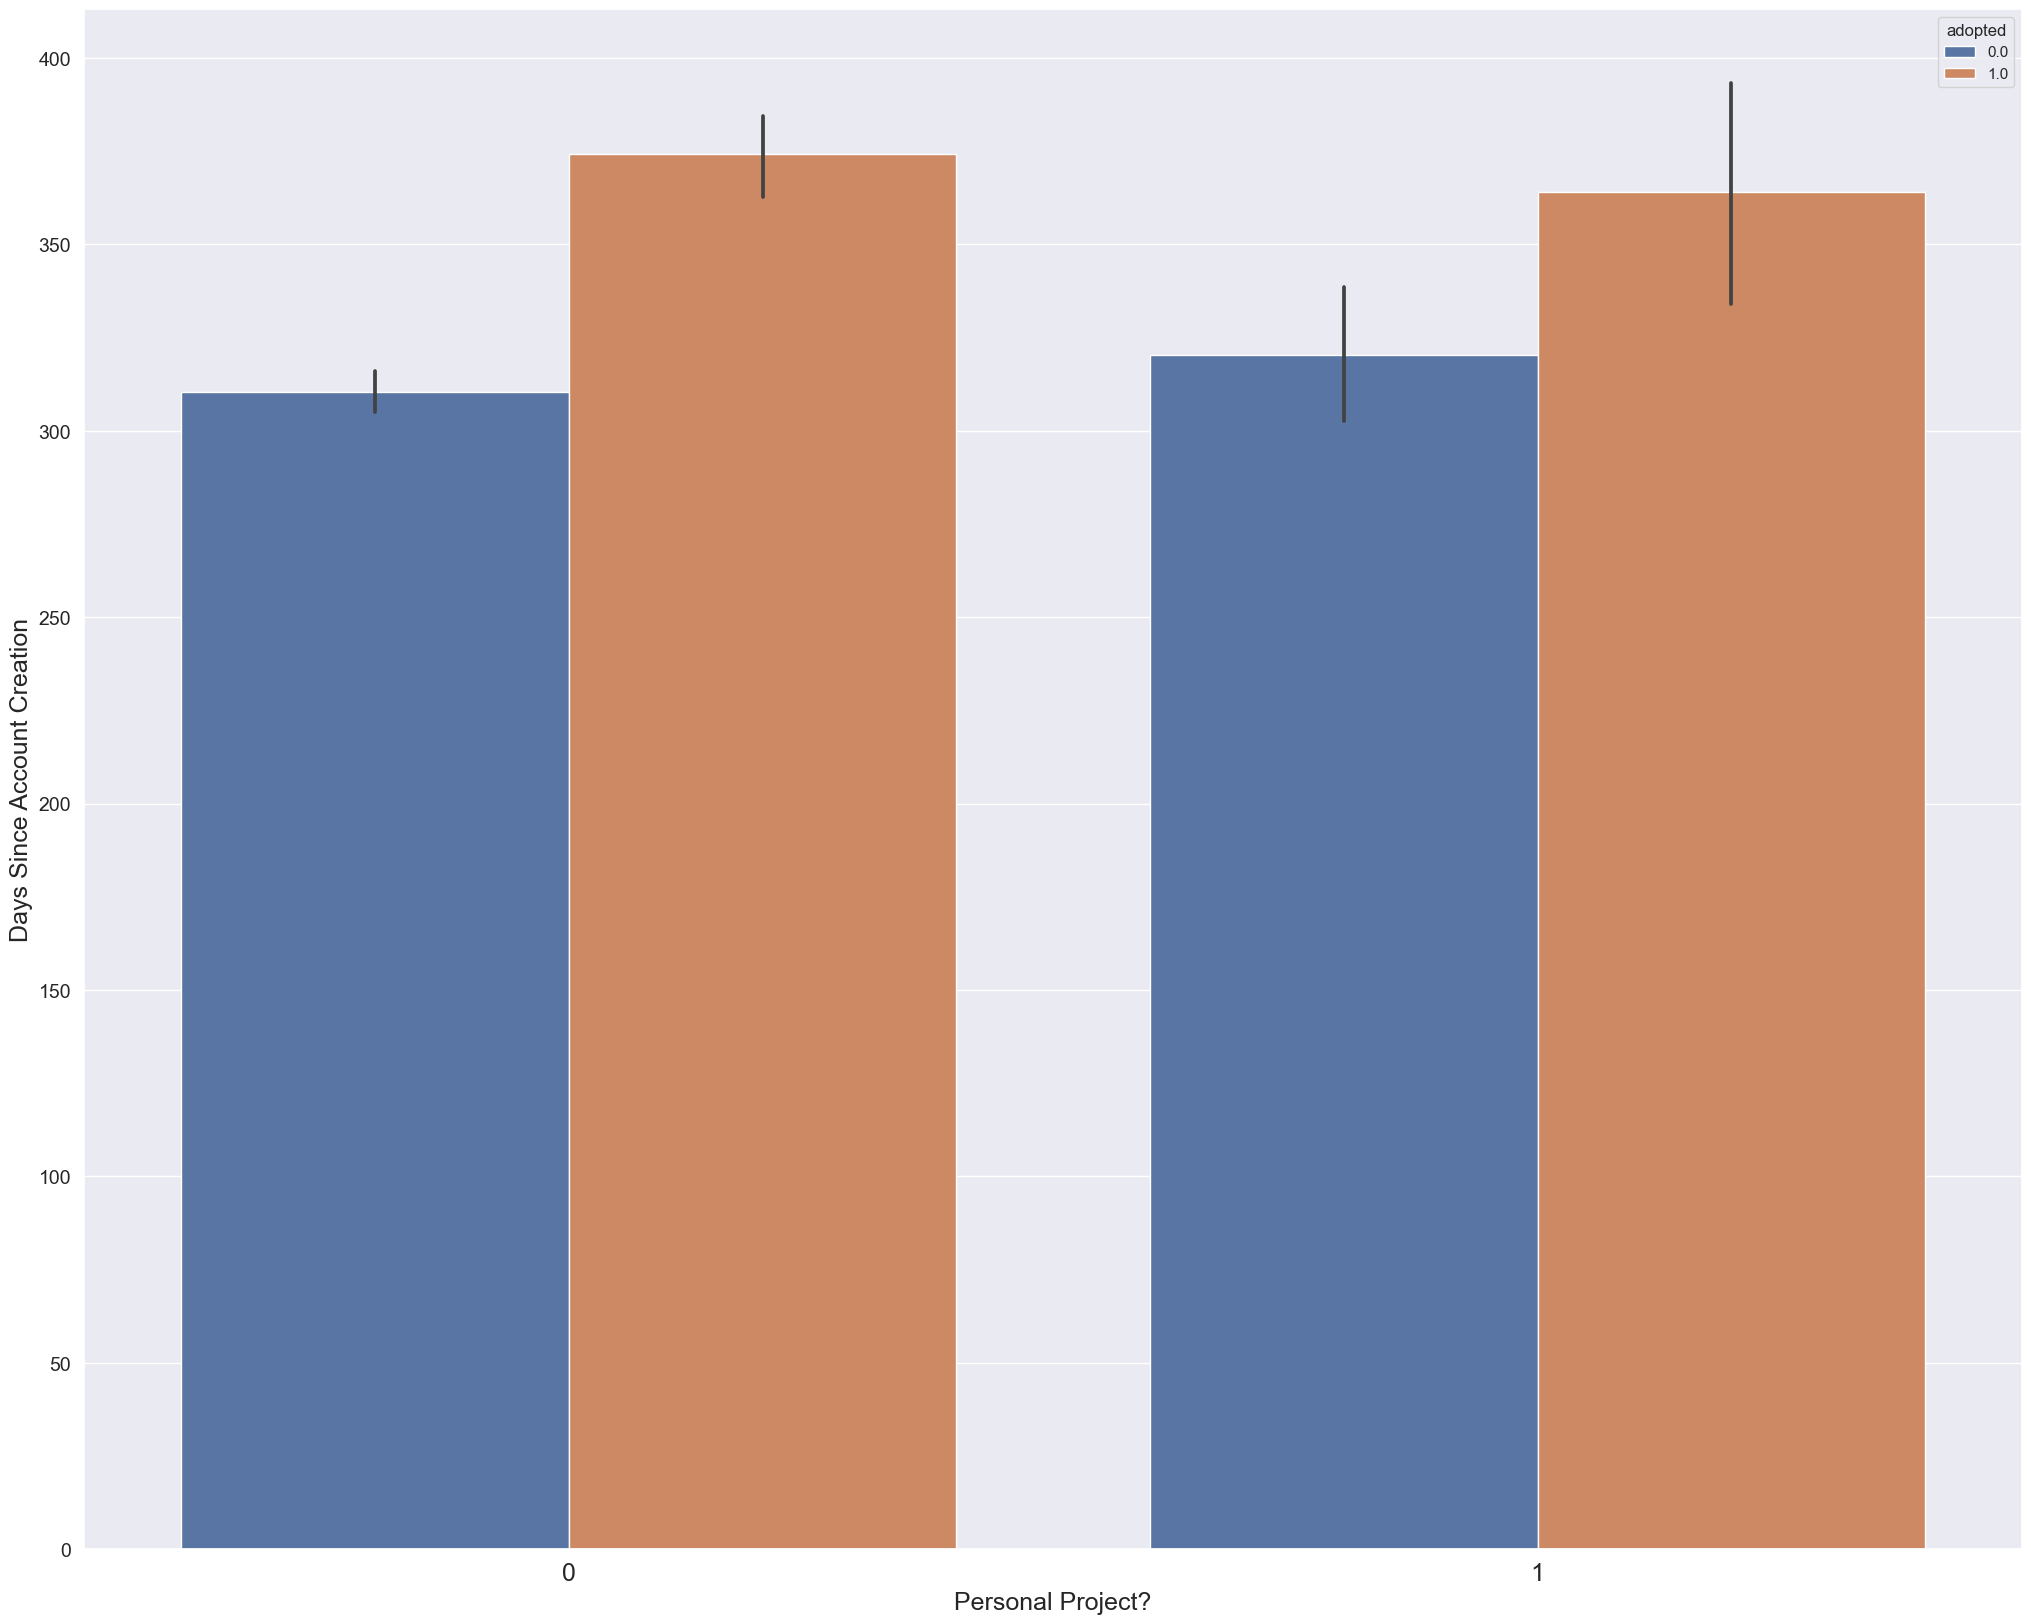

In [113]:
sns.barplot(y=full_users['days_since_creation'], x=full_users['creation_source_PERSONAL_PROJECTS'], hue=full_users['adopted'])
plt.xticks(rotation = 0, fontsize=18)
plt.xlabel('Personal Project?', fontsize=18)
plt.ylabel('Days Since Account Creation', fontsize=18)
plt.yticks(fontsize=14)
plt.show;
plt.savefig('Personal Projects by Days on Platform')


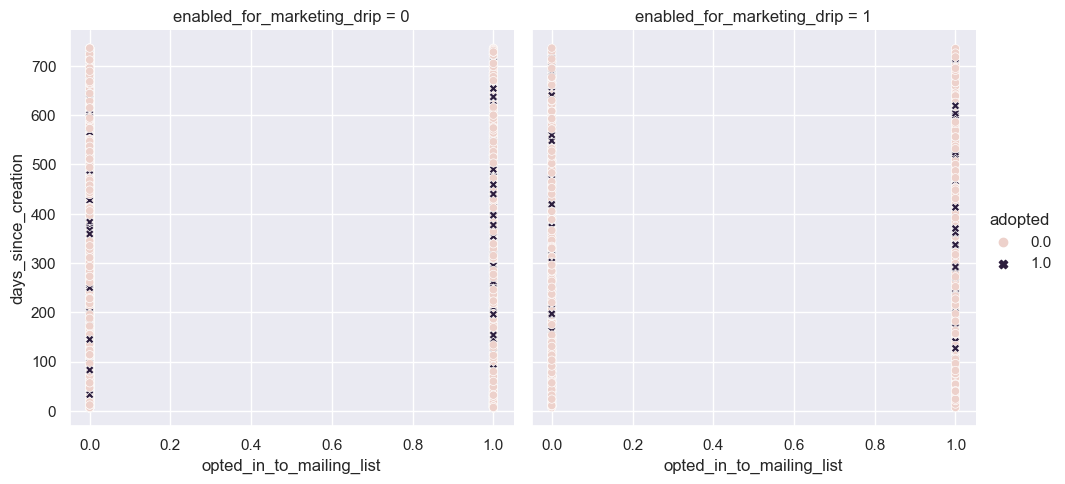

In [117]:
sns.relplot(
    data=full_users,
    x="opted_in_to_mailing_list", y="days_since_creation", col="enabled_for_marketing_drip",
    hue="adopted", style="adopted");
plt.savefig('Marketing Drip and Mailing List Patterns')
### not many insights here; maybe more adopted if opted into mailing list; market drip
### not as important?

So there are some patterns here and some leading tendencies that ML modeling should be able to pick up on.

In [121]:
full_users.head(10)

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,days_since_creation,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803.0,0.0,45,1,0,0,0,0
1,0,0,1,316.0,1.0,203,0,1,0,0,0
2,0,0,94,1525.0,0.0,443,0,1,0,0,0
3,0,0,1,5151.0,0.0,381,1,0,0,0,0
4,0,0,193,5240.0,0.0,505,1,0,0,0,0
5,0,0,197,11241.0,0.0,171,1,0,0,0,0
6,0,1,37,NaN,0.0,537,0,0,0,1,0
7,1,1,74,NaN,NaN,310,0,0,1,0,0
8,0,0,302,NaN,NaN,213,0,0,1,0,0
9,1,1,318,4143.0,1.0,505,0,1,0,0,0


In [130]:
#Need to change the float64 into int64 and fill in NaNs 
full_users.info()
#full_users['invited_by_user_id'].fillna(0, inplace = True)
#full_users['adopted'].fillna(0, inplace = True)
#full_users['invited_by_user_id'] = full_users['invited_by_user_id'].astype('int64')
#full_users['adopted'] = full_users['adopted'].astype('int64')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   opted_in_to_mailing_list            12000 non-null  int64
 1   enabled_for_marketing_drip          12000 non-null  int64
 2   org_id                              12000 non-null  int64
 3   invited_by_user_id                  12000 non-null  int64
 4   adopted                             12000 non-null  int64
 5   days_since_creation                 12000 non-null  int64
 6   creation_source_GUEST_INVITE        12000 non-null  uint8
 7   creation_source_ORG_INVITE          12000 non-null  uint8
 8   creation_source_PERSONAL_PROJECTS   12000 non-null  uint8
 9   creation_source_SIGNUP              12000 non-null  uint8
 10  creation_source_SIGNUP_GOOGLE_AUTH  12000 non-null  uint8
dtypes: int64(6), uint8(5)
memory usage: 621.2 KB


In [136]:
### So only 15.4% of the users are adopted. Not a strongly held trend. They may want to switch 
### to twice in a 7 day period to figure adoption.
full_users['adopted'].value_counts()

0    10398
1     1602
Name: adopted, dtype: int64

In [131]:
### Checking out a baseline assessment with a logistic regression since we have a binary adoption
### choice and want to see which factors influence that adoption. We can work on RFE or others after.
### Splitting into target features and dependent variable
X = full_users.loc[:, full_users.columns!='adopted']
y = full_users.adopted
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [132]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [143]:
###mean_squared_error, r2_score, mean_absolute_error. 
print('The Root Mean Squared Error with Logistic Regression:', round(np.sqrt(mean_squared_error(y_test,y_pred)), 2))
print('The Mean Absolute Error with Logistic Regression:', round(mean_absolute_error(y_test,y_pred), 2))


The Root Mean Squared Error with Logistic Regression: 0.37
The Mean Absolute Error with Logistic Regression: 0.14


In [135]:
### The accuracy score is actually pretty good for a basic logistic run at this.
clf.score(X_test, y_test)

0.865

In [137]:
### Let's try an RFE estimator with logistic regression to see if what we can pull up.
estimator = LogisticRegression(random_state=42)
rfe = RFE(estimator, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)
y_pred_rfe = rfe.predict(X_test)

In [144]:
###mean_squared_error, r2_score, mean_absolute_error. 
print('The Root Mean Squared Error with Logistic Regression:', round(np.sqrt(mean_squared_error(y_test,y_pred_rfe)), 2))
print('The Mean Absolute Error with Logistic Regression:', round(mean_absolute_error(y_test,y_pred_rfe), 2))


The Root Mean Squared Error with Logistic Regression: 0.37
The Mean Absolute Error with Logistic Regression: 0.14


In [141]:
### same estimator so same findings; let's look at the feature rankings next
rfe.score(X_test, y_test)

0.865

In [142]:
### checking out the feature rankings
for i in range(X_train.shape[1]):
	print('Column: %s, Selected %s, Rank: %.3f' % (X_train.columns[i], rfe.support_[i], rfe.ranking_[i]))

Column: opted_in_to_mailing_list, Selected True, Rank: 1.000
Column: enabled_for_marketing_drip, Selected False, Rank: 2.000
Column: org_id, Selected False, Rank: 4.000
Column: invited_by_user_id, Selected False, Rank: 6.000
Column: days_since_creation, Selected False, Rank: 5.000
Column: creation_source_GUEST_INVITE, Selected True, Rank: 1.000
Column: creation_source_ORG_INVITE, Selected False, Rank: 3.000
Column: creation_source_PERSONAL_PROJECTS, Selected True, Rank: 1.000
Column: creation_source_SIGNUP, Selected True, Rank: 1.000
Column: creation_source_SIGNUP_GOOGLE_AUTH, Selected True, Rank: 1.000


Several winners here for influence prediction of adoption:

- opted_in_to_mailing_list, Selected True, Rank: 1.000
- creation_source_GUEST_INVITE, Selected True, Rank: 1.000
- creation_source_PERSONAL_PROJECTS, Selected True, Rank: 1.000
- creation_source_SIGNUP, Selected True, Rank: 1.000
- creation_source_SIGNUP_GOOGLE_AUTH, Selected True, Rank: 1.000